# Milestone 2

**TODO:** General description of our project and what we seek to achieve

## Data Sanitizing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import gzip
%matplotlib inline

In [ ]:
REVIEWS_PATH = "reviews_Grocery_and_Gourmet_Food.json.gz"
META_PATH = "meta_Grocery_and_Gourmet_Food.json.gz"

Before starting our data import and exploration, we first need to convert the data to strict json. As explained in the site [from which the data comes from](http://jmcauley.ucsd.edu/data/amazon/links.html), the data is not in strict json, and thus we can not import as-is in a dataframe. To avoid us the hassle of reading the file in a dictionnary everytime we want to import it in a dataframe, we are going to create new files containing the reviews and metadata in appropriate format.

In [ ]:
def sanitize(path, outpath):
    """Converts a given compressed json to strict json and writes it in a new file

    Parameters
    ----------
    path : str
    The file location of the gzip-compressed json file
    outpath : str
    The path to the desired output file location 

    """
    g = gzip.open(path, 'r')

    out = open(outpath, 'w')

    for l in g:
        out.write(json.dumps(eval(l)) + '\n')
    out.close()

In [ ]:
META_OUTPATH = "cleaned_meta.json"
REVIEWS_OUTPATH = "cleaned_reviews.json"

sanitize(META_PATH, META_OUTPATH)
sanitize(REVIEWS_PATH, REVIEWS_OUTPATH)

## Data Import

Now that our data is in correct format, we can safely import it and have a quick first look.

In [2]:
REVIEWS_PATH = "cleaned_reviews.json"
META_PATH = "cleaned_meta.json"

In [3]:
# Read-in the reviews
reviews = pd.read_json(REVIEWS_PATH, lines=True)

reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1ZQZ8RJS1XVTX,0657745316,gsxrgirl,"[0, 0]","No sugar, no GMO garbage, no fillers that come...",5,Best vanilla I've ever had,1381449600,"10 11, 2013"
1,A31W38VGZAUUM4,0700026444,FIFA Lvr,"[1, 1]","This is my absolute, undisputed favorite tea r...",5,Terrific Tea!,1354752000,"12 6, 2012"
2,A3I0AV0UJX5OH0,1403796890,Alicia b,"[0, 0]",I ordered spongbob slippers and I got John Cen...,1,grrrrrrr,1385942400,"12 2, 2013"
3,A3QAAOLIXKV383,1403796890,"Danny K. Tilley ""Dan Tilley""","[0, 0]",The cart is fine and works for the purpose for...,3,Storage on Wheels Cart,1307836800,"06 12, 2011"
4,AB1A5EGHHVA9M,141278509X,CHelmic,"[1, 1]",This product by Archer Farms is the best drink...,5,The best drink mix,1332547200,"03 24, 2012"


For efficiency as well as memory purposes, we are going to first drop some of the columns that we are not going to use in our later analysis.

In [4]:
#Drop some of the columns
reviews = reviews.drop(columns=['reviewerName', 'helpful', 'reviewTime', 'summary'])

We are also convert the unixReviewTime column to the datetime type.

In [5]:
#Convert the utc timestamp to readable dates
reviews['unixReviewTime'] = pd.to_datetime(reviews['unixReviewTime'],unit='s')

reviews.head()

,reviewerID,asin,reviewText,overall,unixReviewTime
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",5,2013-10-11
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",5,2012-12-06
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24


## Data exploration

**TODO:** First exploration of the data (plotting, similar to what is in readme)

## Labelling data

Using the Amazon dataset, our goal is to detect any potential harmful products by analyzing the user reviews and classifying them as presenting or not a possible health threat. Unfortunately, we lack the annotated data that would be needed to build a classifier.

We will thus create our own annotated data by using **empath**. **Empath** is a python library that can be used to analyze documents over a set of predefined categories, and even generate new categories.  

We start by importing the library.

In [6]:
from empath import Empath

We then create a new lexical category **healthConcerns** as a combination of the seeds words **health**, **danger** and **food poisoning**.

In [7]:
lexicon = Empath()

lexicon.create_category('healthConcerns', \
                        seeds=['health', 'danger', 'food poisoning'])


["health", "danger", "welfare", "human_life", "illness", "sickness", "necessity", "safety", "responsibility", "mental_state", "dangers", "well-being", "risk", "lifemate", "knowledge", "survival", "consequence", "humanity", "recovery", "exposure", "risks", "capacity", "wellbeing", "peril", "potential", "responsibilities", "downfall", "death", "loyalty", "bloodline", "fear", "judgement", "poverty", "responsible", "threat", "condition", "importance", "treatment", "current_state", "disease", "discipline", "top_priority", "judgment", "affairs", "healing", "cruelty", "human_race", "sacrifice", "ensure", "demise", "hardship", "separation", "vital", "healer", "losses", "likelihood", "environment", "Psy", "hazard", "corruption", "independence", "future", "own_safety", "needs", "killing", "normalcy", "Council", "suffering", "stability", "virtue", "disability", "sacrifices", "conditions", "free_will", "failure", "therefore", "carelessness", "involvement", "mindset", "unborn_child", "relations", "

In [8]:
def analyze(x):
    ret = lexicon.analyze(x, categories=["healthConcerns"])
    if (ret == None):
        return 0.0
    else:
        return ret.get('healthConcerns')

We now create a new column do our dataframe, obtained by analyzing the reviews and assigning them a score. The higher the score is, the more that review exposes possible health concerns. 

In [55]:
empathy = reviews.copy()
empathy['healthScore'] = empathy['reviewText'].apply(lambda x : analyze(x))

empathy.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,healthScore
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",5,2013-10-11,0.0
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",5,2012-12-06,0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,0.0
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,0.0


Now that all our reviews have been assign a score, let's have a look at its distribution.

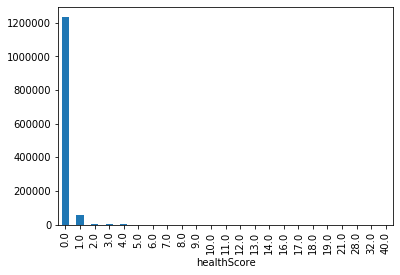

In [56]:
empathy.groupby(by='healthScore').count()['reviewText'].plot.bar()

As expected, we observe that a vast majority of the reviews don't expose any kind of health-related issues (symbolized by the pic at x = 0). Let's dive deeper and have a closer look at the reviews with a score bigger than 0.

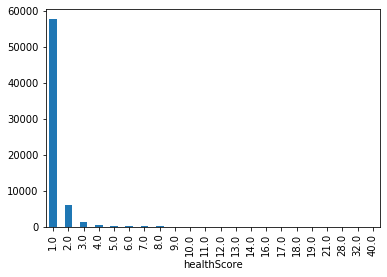

In [57]:
empathyScore = empathy[empathy['healthScore'] > 0]

empathyScore.groupby(by='healthScore').count()['reviewText'].plot.bar()

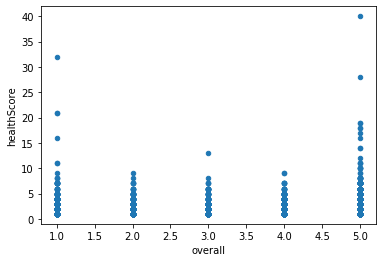

In [58]:
empathyScore.plot.scatter('overall', 'healthScore')

We observe here something pretty unexpected : most of the reviews with a high healthScore have an associated rating of 3 or more, with the highest healthScore at x=5. A fair assumption would be that a reviewer exposed to health issues due to a product would attribute it a low score, which is not the case here. Let's have a look at the reviews themselves now, to gain more insights.

In [59]:
empathyScore[empathyScore['overall'] == 5].sort_values(by='healthScore', ascending=False).head()

,reviewerID,asin,reviewText,overall,unixReviewTime,healthScore
632161,A1FLQ698D9C0C8,B002P0Q14C,Tea Antioxidants----------------Antioxidants c...,5,2009-09-13,40.0
388784,A1J7FP5XCCSHSM,B001AG6BMO,333 Uses for Coconut Oil*Coconut Oil Is:Anti-b...,5,2012-03-22,28.0
286194,A356RFKNIG043B,B000R71WMQ,I can't begin to praise apple cider vinegar (a...,5,2014-04-05,19.0
640651,A1FLQ698D9C0C8,B002TCGR3G,Green tea's potential benefits for everything ...,5,2009-10-18,19.0
436584,A3RR2P5IS3DGPR,B001ELL288,These Eden Dried Montmorency Cherries are perf...,5,2010-06-11,18.0


In [60]:
[x[:1000] for x in empathyScore[empathyScore['overall'] == 5] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:2]]

['Tea Antioxidants----------------Antioxidants can help the body protect itself against free radicals--molecules that can damage cells. Antioxidants in tea called flavonoids can do that.Whether iced or hot, Teas made from real tea leaves provide more than great taste. Like fruits and vegetables, regular and decaffeinated brewed teas contain natural antioxidants called flavonoids* (10-22, 68, 69). Research suggests that antioxidants can be beneficial to health by helping the body protect itself from the harmful effects of "free radicals" (1-9, 26-30, 73-75). Free radicals, molecules which occur in the environment and are naturally produced by the body, can cause damage to cells. Chronic damage by free radicals is one factor thought to contribute to the development of many chronic diseases including heart disease or cancer. An average cup of brewed green or black tea has 150-200 mg of flavonoids (10-21).Currently, tea\'s potential health benefits are the focus of many scientific studies,

As we see with those reviews, there seems to be something off with them (note that, for readability purposes, we only show the first thousand characters of those reviews) : they look more like some ad of the product's benefits/usages than actual reviews. Our initial assumption seems thus accurate : even though those "reviews" are health-related, they are not what we are looking for. We are thus going to ignore them. Let's continue our analysis with the reviews with score 3 and 4.

In [61]:
[x[:1000] for x in \
 empathyScore[empathyScore['overall'] == 4] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:3]]

["Performance power bars are a great snack between meals. I eat them when I don't want to pig out, because in this world, being fat is considered bad, and for good reason. Rather than eating more than my fair share, I skip desserts and go for a power bar instead. Obesity is a serious health problem that too many people don't take seriously enough, they don't have the will power to resist their hunger cravings. Performance power bar offers another tool in the fight against unsightly obesity, not to mention the serious health risks, joint and feet problem that being too fat brings. I use the power bars as a way to control my weight so I don't get too heavy.  I take responsibility for my own diet, and I need snacks like these to keep those hunger cravings at bay.  They are a little harder than I would like, but still they do the job.  The protein takes away the sugar cravings, which are a death knell to any diet and well being.  I look forward to trying the other flavors and formulas.",
 

In [62]:
[x[:1000] for x in \
 empathyScore[empathyScore['overall'] == 3] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:3]]

["Yerba Mate, like caffeine, is a stimulant.  Both increase heart rate, blood pressure and impact various metabolic processes that work cooperatively to maintain homeostasis within your body.  In moderate amounts each can be tolerated without incident in 'well' adults. Yerba Mate compounds are not likely to pose a risk for healthy 'well' adults who occasionally drink it.However, some studies indicate that *certain people who drink large amounts of yerba mate over prolonged periods may be at increased risk of certain types of cancer, such as cancer of the mouth, esophagus and lungs. Those with Thyroid or auto immune conditions are at greater risk for developing thyroid goiters, cancers and lymphatic cancers.  Smoking, drinking or prolonged high blood sugar in combination with yerba mate seems to greatly increase serious health risks such as cancer.One possible explanation is that mate contains polycyclic aromatic hydrocarbons (PAHs), which are known to be carcinogenic. (Tobacco smoke an

We see that reviews with a 4 score don't really assert the reviewed product's health issues, but its competitors or other aspects. Whereas the reviews rated 3-stars seem to correspond to what we were looking for.

Thus, for our labelled data, we're going to limit ourselves to the reviews with a healthScore strictly positive, and with a rating smaller or equal to 3.

In [63]:
empathy['danger'] = np.where(np.logical_and(empathy['healthScore'] > 0., empathy['overall'] < 4), \
                             True, False)


empathy.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,healthScore,danger
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",5,2013-10-11,0.0,False
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",5,2012-12-06,0.0,False
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,0.0,False
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,0.0,False
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,0.0,False


In [68]:
print("Number of reviews that we will use as labelled data : {}" \
      .format(len(empathy[empathy['danger']])))

Number of reviews that we will use as labelled data : 14607


## What's up next

Now that we have created some labelled data, we will now be able to build a classifier able to classify reviews as exposing potential health threaths. This will serve as both a way to handle potentially new reviews, but also detect reviews that we potentially missed earlier. 

Notice that we made a few assumptions during our label creation, which might not always hold. Notice also that our healthConcern category created in empath might not be exhaustive enough to capture all health-related issues. A classifier would be able to solve those issues.

Once we have our classifier and (hopefully) all our reviews, we will explore them in depth, trying to draw any meaningful insights (for example if we see any meaningful pattern in the health-related reviews on a time basis, if there are some brands that demarks themselves with the number of their products that exposes such concerns etc..)